In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys

In [3]:
sys.path.append(r'/Users/alexandershubert/git/statslib')

In [266]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [21]:
import statsmodels.api as sm

In [5]:
import statslib as stb

In [7]:
pa = stb.utils.common.print_attributes
ddff = stb.utils.dframe.display_full_df

In [8]:
figsize = (8*1.6, 8)

In [206]:
path = '/Users/alexandershubert/git/statslib/tests/data/df.csv'
df = pd.read_csv(path);
df = stb.utils.dframe.to_pd_todatetime(df, 'day', day_only=False)
y = df.set_index('day').squeeze().rename('y')

In [207]:
path = '/Users/alexandershubert/git/statslib/tests/data/x.csv'
df = pd.read_csv(path);
df = stb.utils.dframe.to_pd_todatetime(df, 'day', day_only=False)
X = df.set_index('day')

***

In [232]:
class DesignMatrix:
    def __init__(self, y, f, X, gs, add_const=True):
        self.y = y.rename('y')
        self.f = f
        self.v = self.f(y)
        if X is None:
            self.dm_ext = pd.concat([self.y, self.v], axis=1)
            self.dm = self.dm_ext.dropna(axis=0)
            self.names={'y': y.name}
            self.gX = None
        else:
            self.X = X
            self.gs = gs
            self.names = dict(zip([f'g{i}' for i in range(len(X.columns))], X.columns.tolist()))
            if add_const:
                self.names.update({'const': 'const'})
            self._inv_names = {v:k for k,v in self.names.items()}
            self.gX = X.agg(dict(zip(X.columns.tolist(), gs)))
            if add_const:
                self.gX = sm.tools.tools.add_constant(self.gX)
            self.gX.rename(columns=self._inv_names, inplace=True)
            self.dm_ext = pd.concat([self.y, self.v, self.X, self.gX], axis=1)
            self.dm = pd.concat([self.y, self.v, self.gX], axis=1).dropna(axis=0)
            self.gX = self.dm[self.names.keys()]
            self.gX = self.gX[sorted(self.gX.columns)]
            self.names.update({'y': y.name})

In [233]:
from enum import Enum
import inspect

class CalibType(Enum):
    sm = 'statsmodels'
    sk = 'sklearn'
        
class GeneralCalibrator:    
    def __init__(self, cf, kwargs=None):
        self.cf = cf
        self.kwargs = kwargs
        if 'sklearn' in cf.__module__:
            self.calib_type = CalibType.sk
        elif 'statsmodels' in cf.__module__:
            self.calib_type = CalibType.sm
        else:
            raise NotImplementedError(f'calibrator from package {cf.__module__} not accomodated yet')

In [234]:
class GeneralModel:
    def __init__(self, gc, DM):
        self.gc = gc
        self.DM = DM
        self.calibrator = None
        self.fitted = None
        self.v_hat = None
        
    def exog(self, idx):
        return DM.gX.iloc[idx] if DM.gX is not None else None
    
    def endog(self, idx):
        return DM.dm.v.iloc[idx]
    
    def fit(self, idx, **kwargs):
        if self.gc.calib_type is CalibType.sm:
            self.calibrator = self.gc.cf(endog = self.endog(idx), 
                                         exog = self.exog(idx), 
                                         **self.gc.kwargs)
            self.fitted = self.calibrator.fit(**kwargs)
    
    def forecast(self,idx):
        if 'start' in inspect.signature(gm.fitted.predict).parameters:
            self.v_hat = self.fitted.predict(
                          self.endog(idx).index.min(), 
                          self.endog(idx).index.max(),
                          exog=self.exog(idx))
        else:
            self.v_hat = self.fitted.predict(exog=self.exog(idx))


In [528]:
import math
plt.style.use('ggplot')
class CrossValidation:
    def __init__(self, gm, splits, metric):
        self.splits = splits
        self.metric = metric
       
    def run(self):
        metric_list = []
        L = 2
        K = math.ceil(len(splits) / L)
        i = j = 0
        fig, axs = plt.subplots(K, L, figsize=(15, 15))
        for train_index, test_index in splits:
            gm.fit(train_index)
            gm.forecast(test_index)
            v_hat = gm.v_hat
            y0 = DM.dm.y.iloc[train_index].tail(DM.f.n)
            y_hat = f.inv(v_hat, y0=y0, idx=v_hat.index)
            y_train = DM.dm.y.iloc[train_index]
            y = DM.dm.y.iloc[test_index]
            metric_val = self.metric(y, y_hat)
            metric_list.append(metric_val)

            y_hat.at[y0.index.max()] = y0[y0.index.max()]
            y_hat.sort_index(inplace=True)
            axs[i,j].set_title(r'$\varepsilon_{CV}=$' + f'{metric_val:.4f}')
            y_train.plot(ax=axs[i,j], c='#988ED5')
            y_hat.plot(ax=axs[i,j], c='#8EBA42')
            y.plot(ax=axs[i,j], c='#E24A33')
            axs[i,j].legend(['$y_t$', '$\hat{y}$', '$y_{true}$'])
            j += 1
            if j % L == 0:
                i += 1
                j = 0
        CV_error = np.mean(metric_list)
        CV_std =  np.std(metric_list)
        print(f'CV_error: {CV_error:.4f} +/- {CV_std:.4f}')
        plt.tight_layout()
        plt.show()
        return CV_error, CV_std

In [529]:
def plot_to_grid(df, curves, title, legend_on_a_side=False):
    L = 3
    K = math.ceil(len(curves) / L)
    i = j = 0
    fig, axs = plt.subplots(K, L, figsize=(15, 15))
    for curve in curves:
        df[curve].plot(ax=axs[i, j])
        axs[i, j].legend([curve])
        j += 1
        if j % L == 0:
            i += 1
            j = 0
    plt.suptitle(title)
    if legend_on_a_side:
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

***

In [530]:
f = stb.transforms.pct_change()

In [531]:
y = y.resample('D').mean().fillna(method='ffill').rename('A')

In [532]:
g0 = stb.transforms.pct_change()

In [533]:
g1 = stb.transforms.difference_operator(1,None,0, inv_specification=[[-1],[1]])

In [534]:
g2 = stb.transforms.log_return(3)

In [535]:
X = X.resample('D').mean().fillna(method='ffill')

In [536]:
DM = DesignMatrix(y, f, X, [g0,g1,g2] )

***

In [545]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=6)
splits = [(train_idx, test_idx)for train_idx, test_idx in tscv.split(DM.dm.index)]

In [546]:
metric = stb.metrics.mean_absolute_percentage_error

/opt/anaconda3/envs/statslib_env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/statslib_env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/statslib_env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/statslib_env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


CV_error: 0.0641 +/- 0.0417


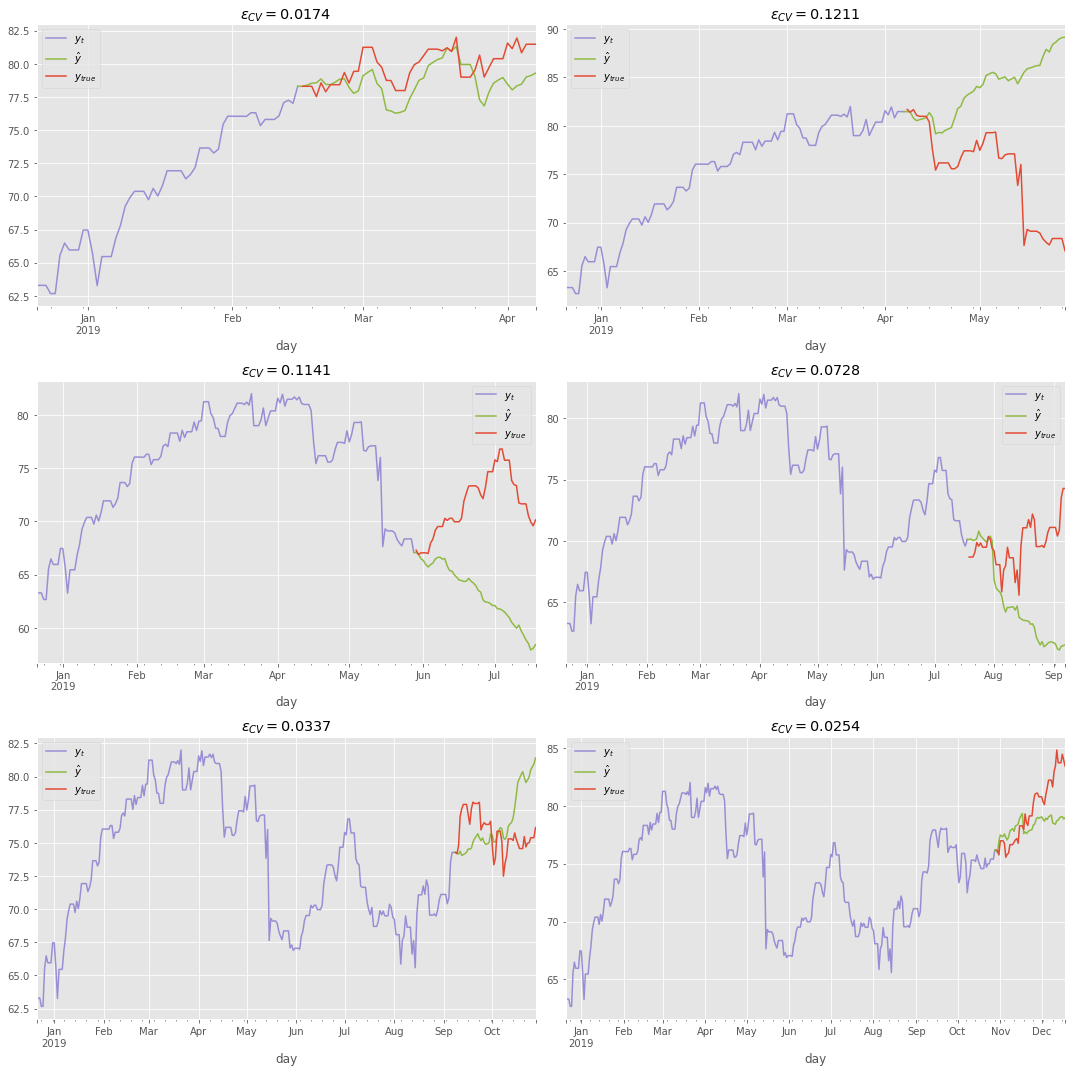

In [547]:
gc = GeneralCalibrator(sm.tsa.arima.ARIMA, 
                       dict(order=(2,1,3), 
                       trend='n', 
                       enforce_stationarity=True))
gm = GeneralModel(gc, DM)

cv = CrossValidation(gm, splits, metric=metric)
cv_error, cv_std = cv.run()

In [540]:
print(gm.fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                      v   No. Observations:                  273
Model:                 ARIMA(2, 1, 3)   Log Likelihood                 795.048
Date:                Wed, 10 Mar 2021   AIC                          -1570.096
Time:                        15:49:04   BIC                          -1534.038
Sample:                    12-21-2018   HQIC                         -1555.620
                         - 09-19-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        5.25e-11   1.63e-08      0.003      0.997   -3.19e-08     3.2e-08
g0             0.1875      0.051      3.647      0.000       0.087       0.288
g1             0.0004   7.24e-05      5.876      0.0

CV_error: 0.0567 +/- 0.0298


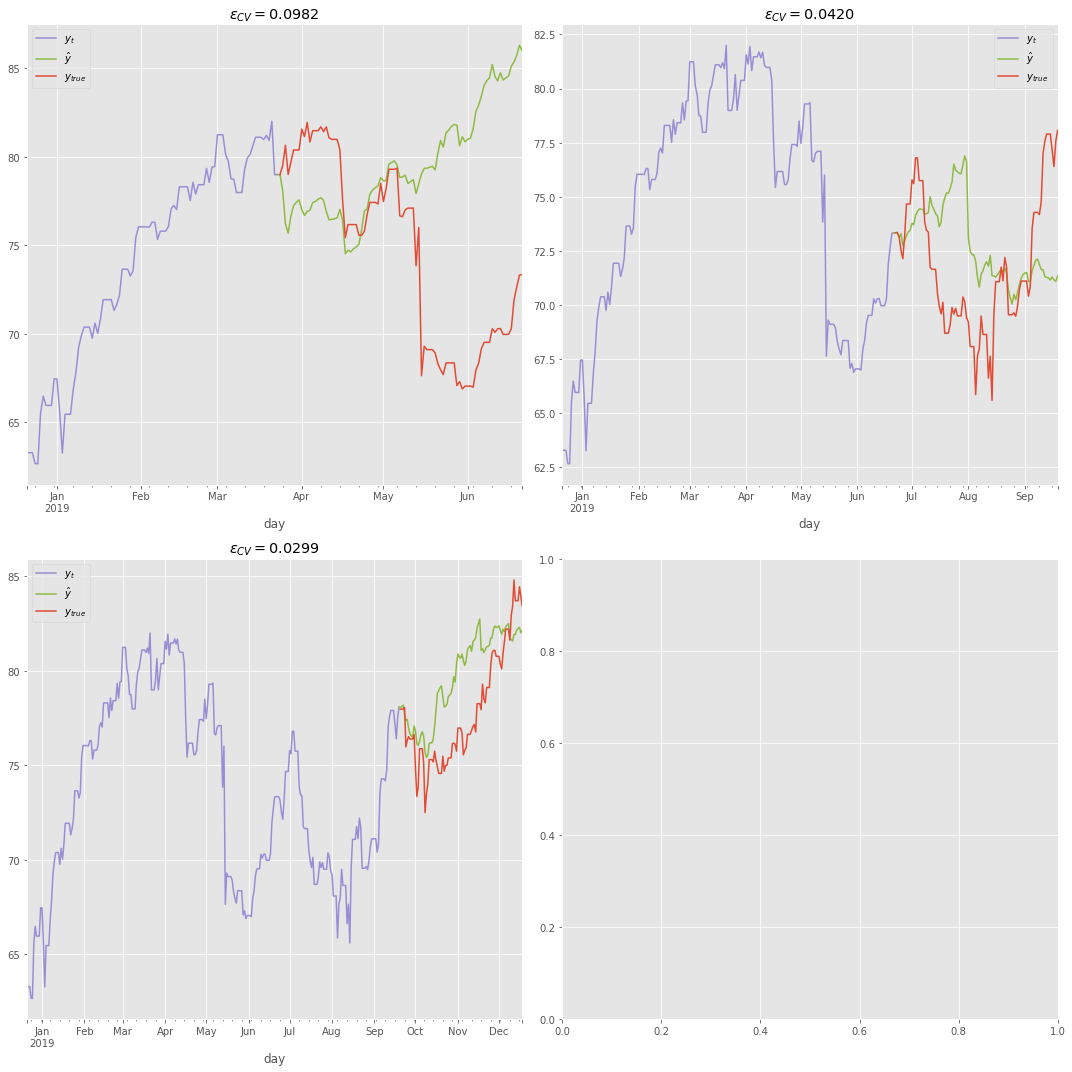

(0.05671395650837719, 0.029771144045791904)

In [541]:
gc = GeneralCalibrator(sm.OLS, dict())
gm = GeneralModel(gc, DM)
cv = CrossValidation(gm, splits, metric)
cv.run()

In [191]:
print(gm.fitted.summary())

AttributeError: 'NoneType' object has no attribute 'summary'

In [192]:
gc = GeneralCalibrator(sm.RLM, dict())
gm = GeneralModel(gc, DM)
cv = CrossValidation(gm, splits, metric)
cv.run()

TypeError: loop of ufunc does not support argument 0 of type NoneType which has no callable conjugate method